# Systematic Literature Review DX in Shipping - Citation and Co-citation analysis

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain  # Correct import
from collections import Counter
import numpy as np
import powerlaw
# import json
# import numpy as np
# from collections import Counter

# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.tokens import DocBin

# from gensim import corpora
# from gensim.models import LdaModel
# from sklearn.feature_extraction.text import TfidfVectorizer

# from transformers import BertTokenizer, BertModel
# import torch
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\anaconda3\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\anaconda3\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "C:\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.i

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\anaconda3\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\anaconda3\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "C:\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.i

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\anaconda3\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\anaconda3\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "C:\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.i

AttributeError: _ARRAY_API not found

## Read the DB in

In [2]:
# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [3]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'referenced_works'
# List all column names containing the substring using list comprehension
matching_columns = [k for k in lit.columns if substring in k]
matching_columns.remove('referenced_works_count')
#print(matching_columns)
#print(lit['referenced_works_0'])
#print(lit['id'])

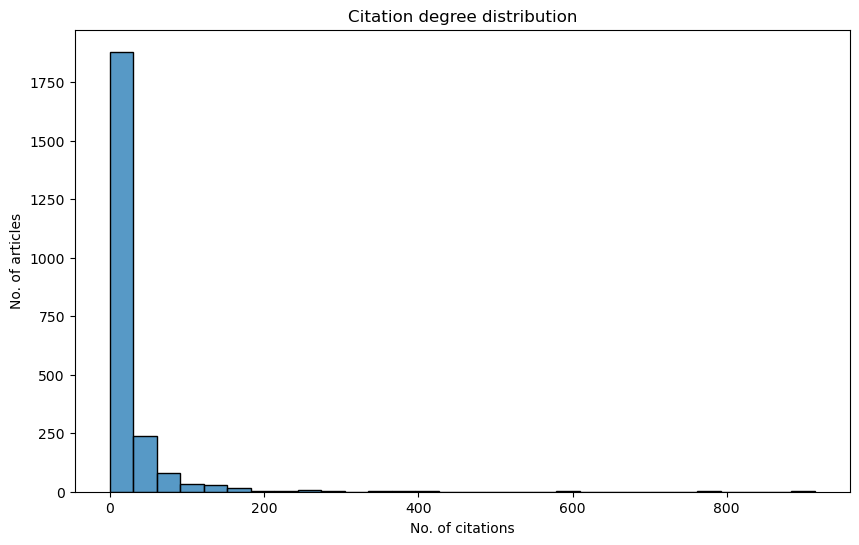

In [5]:
# Let's first do an analysis of cited_by_count
cvals = lit['cited_by_count'].dropna()

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the degree distribution as a histogram
sns.histplot(cvals, bins=30, kde=False, stat="count")
plt.xlabel("No. of citations")
plt.ylabel("No. of articles")
plt.title("Citation degree distribution")
plt.show()

In [6]:
# LEt's see if it could be a powerlaw
# Statistical analysis for powerlaw fitting

# Step 1: Fit the power-law and other distributions
fit = powerlaw.Fit(cvals)

# Step 3: Compare power-law with other distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Power law vs. Exponential: R={R}, p={p}")

R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Power law vs. Lognormal: R={R}, p={p}")

R, p = fit.distribution_compare('power_law', 'truncated_power_law')
print(f"Power law vs. Truncated Power law: R={R}, p={p}")

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Power law vs. Exponential: R=9.099262948280709, p=0.040492015265239475
Power law vs. Lognormal: R=-0.013104277915069407, p=0.0616816976507625
Power law vs. Truncated Power law: R=7.007118938417989e-07, p=0.9990554505434153


C:\anaconda3\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


In [7]:
# Let's build the graph of co-citations
node_ids = lit['id'].tolist()
G = nx.Graph()

for index, row in lit.iterrows():
    if not pd.isnull(row['id']):
        for c in matching_columns:
            if not pd.isnull(row[c]):
                # we only want to focus on co-citations when it comes to the graph
                if (row[c] in node_ids):
                    G.add_edge(row['id'], row[c])

In [8]:
print(G.number_of_nodes())

1298


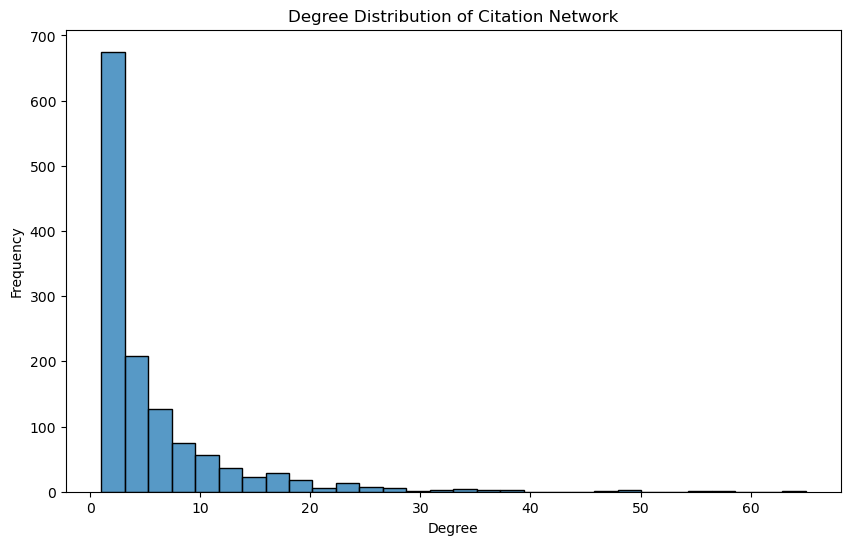

In [9]:
# Assuming G is your citation network graph
# Get a list of all degrees in the network
degrees = [deg for node, deg in G.degree()]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the degree distribution as a histogram
sns.histplot(degrees, bins=30, kde=False, stat="count")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution of Citation Network")
plt.show()

In [10]:
# Statistical analysis for powerlaw fitting

# Step 1: Fit the power-law and other distributions
fit = powerlaw.Fit(degrees)

# Step 3: Compare power-law with other distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Power law vs. Exponential: R={R}, p={p}")

R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Power law vs. Lognormal: R={R}, p={p}")

R, p = fit.distribution_compare('power_law', 'truncated_power_law')
print(f"Power law vs. Truncated Power law: R={R}, p={p}")

Calculating best minimal value for power law fit
Power law vs. Exponential: R=1.3306013469871032, p=0.3281990011465791
Power law vs. Lognormal: R=0.0002582790401728374, p=0.9776298790623232
Power law vs. Truncated Power law: R=-0.027050450360588396, p=0.8160751311601542


Assuming nested distributions


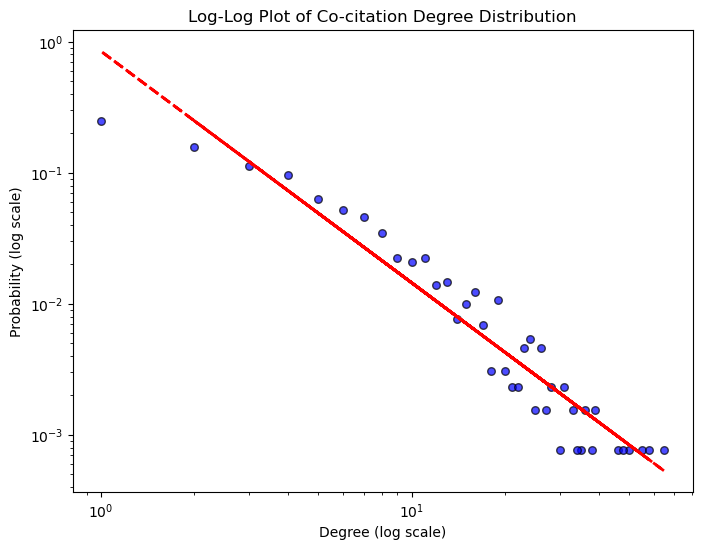

Slope: -1.7682132421361874, Intercept: -0.16382794519668037


In [12]:
# check for power-low distribution
# Step 1: Calculate degree frequencies
degree_counts = Counter(degrees)
degree, count = zip(*degree_counts.items())

# Normalize the counts to get the probability of each degree
count = np.array(count) / sum(count)

# Step 2: Plot on log-log scale
plt.figure(figsize=(8, 6))
plt.scatter(degree, count, color="b", s=30, alpha=0.7, edgecolor='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (log scale)")
plt.ylabel("Probability (log scale)")
plt.title("Log-Log Plot of Co-citation Degree Distribution")

# Optional: add a line of best fit to visualize linearity
slope, intercept = np.polyfit(np.log(degree), np.log(count), 1)
plt.plot(degree, np.exp(intercept) * np.power(degree, slope), color="red", linestyle="--", linewidth=2)

plt.show()
print(f'Slope: {slope}, Intercept: {intercept}')

In [13]:
# Node degree (number of connections) can represent influence in the network
influential_papers = sorted(G.degree, key=lambda x: x[1], reverse=True)
print("Most influential papers:", influential_papers[:10])

Most influential papers: [('https://openalex.org/W3041382323', 65), ('https://openalex.org/W4399283331', 58), ('https://openalex.org/W2978644098', 55), ('https://openalex.org/W2964482263', 50), ('https://openalex.org/W4400493457', 48), ('https://openalex.org/W4308036928', 46), ('https://openalex.org/W2944924828', 39), ('https://openalex.org/W2917580293', 39), ('https://openalex.org/W4205557186', 38), ('https://openalex.org/W4225993858', 36)]


In [17]:
top_papers_ids = [item[0] for item in influential_papers[:10]]
top_papers_ids

['https://openalex.org/W3041382323',
 'https://openalex.org/W4399283331',
 'https://openalex.org/W2978644098',
 'https://openalex.org/W2964482263',
 'https://openalex.org/W4400493457',
 'https://openalex.org/W4308036928',
 'https://openalex.org/W2944924828',
 'https://openalex.org/W2917580293',
 'https://openalex.org/W4205557186',
 'https://openalex.org/W4225993858']

In [39]:
pd.set_option('display.max_columns', None)  

In [41]:
display(lit[lit['id'] == top_papers_ids[9]]['title'])

1560    Digitalization in Maritime Transport and Seapo...
Name: title, dtype: object

In [18]:
top_papers_ids = [item[0] for item in influential_papers]
lit[lit['id'].isin(top_papers_ids)]

,id,doi,title,display_name,publication_year,publication_date,ids_openalex,ids_doi,language,primary_location_is_oa,...,abstract_inverted_index_PMBM_1,abstract_inverted_index_configurations.The_0,abstract_inverted_index_available.The_0,abstract_inverted_index_shown_1,abstract_inverted_index_applications.For_0,abstract_inverted_index_filter.The_0,abstract_inverted_index_connectivity.Smart_0,"abstract_inverted_index_costefficiency,_0",abstract_inverted_index_trade.This_0,abstract_inverted_index_remotely-piloted)_0
0,https://openalex.org/W4401344941,https://doi.org/10.1155/2024/5225558,Predictive Analysis of Maritime Congestion Usi...,Predictive Analysis of Maritime Congestion Usi...,2024.0,2024-01-01,https://openalex.org/W4401344941,https://doi.org/10.1155/2024/5225558,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://openalex.org/W4402480811,https://doi.org/10.12716/1001.18.03.12,VerifAI: Framework for Functional Verification...,VerifAI: Framework for Functional Verification...,2024.0,2024-01-01,https://openalex.org/W4402480811,https://doi.org/10.12716/1001.18.03.12,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,https://openalex.org/W4401641977,https://doi.org/10.3390/s24165310,An End-to-End Deep Learning Framework for Faul...,An End-to-End Deep Learning Framework for Faul...,2024.0,2024-08-16,https://openalex.org/W4401641977,https://doi.org/10.3390/s24165310,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,https://openalex.org/W4401399426,https://doi.org/10.5194/tc-18-3471-2024,The AutoICE Challenge,The AutoICE Challenge,2024.0,2024-08-07,https://openalex.org/W4401399426,https://doi.org/10.5194/tc-18-3471-2024,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,https://openalex.org/W4399053898,https://doi.org/10.3390/s24113458,Enhancing Maritime Cybersecurity through Opera...,Enhancing Maritime Cybersecurity through Opera...,2024.0,2024-05-27,https://openalex.org/W4399053898,https://doi.org/10.3390/s24113458,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,https://openalex.org/W2972656991,https://doi.org/10.1109/access.2019.2941364,Disturbance-Observer-Based Sliding Mode Contro...,Disturbance-Observer-Based Sliding Mode Contro...,2019.0,2019-01-01,https://openalex.org/W2972656991,https://doi.org/10.1109/access.2019.2941364,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2314,https://openalex.org/W3134531044,https://doi.org/10.1109/access.2021.3063836,Enhanced Target Ship Tracking With Geometric P...,Enhanced Target Ship Tracking With Geometric P...,2021.0,2021-01-01,https://openalex.org/W3134531044,https://doi.org/10.1109/access.2021.3063836,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2315,https://openalex.org/W4312656761,https://doi.org/10.1109/access.2022.3215646,Time-Critical Maritime UAV Mission Planning Us...,Time-Critical Maritime UAV Mission Planning Us...,2022.0,2022-01-01,https://openalex.org/W4312656761,https://doi.org/10.1109/access.2022.3215646,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2321,https://openalex.org/W4323065993,https://doi.org/10.1109/access.2023.3252013,A Novel Bias-TSP Algorithm for Maritime Patrol,A Novel Bias-TSP Algorithm for Maritime Patrol,2023.0,2023-01-01,https://openalex.org/W4323065993,https://doi.org/10.1109/access.2023.3252013,en,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.0
285.0


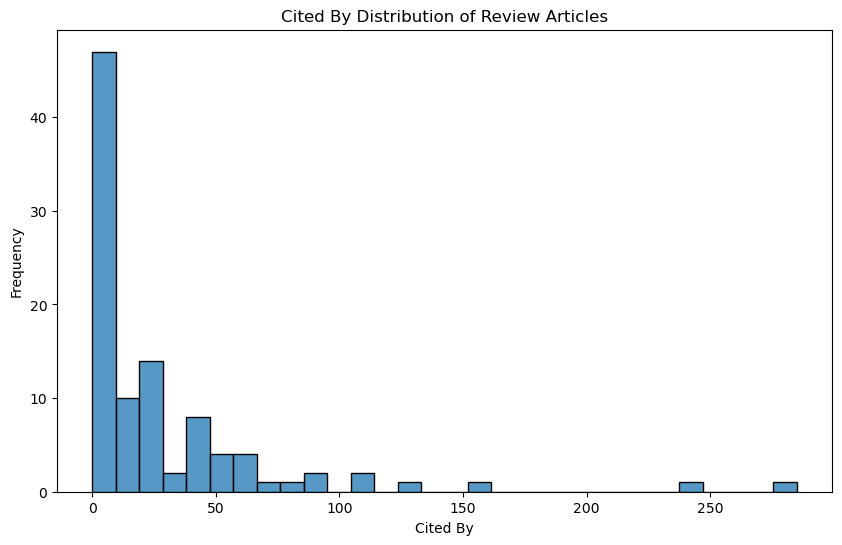

[25, 10, None, 1, 6, 4, None, 30, 1, None, 3, 5, None, None, 16, 1, 3, 9, 1, 1, 1, None, 11, 50, 12, 7, 2, 13, 22, None, 7, 65, 8, 5, None, 2, 14, 4, 13, 9, 6, 20, 1, 2, 7, 19, 24, None, 7, 16, 19, 46, 1, None, 19, 1, 24, 13, 12, 17, 9, None, 2, 7, 1, None, None, 13, 19, 14, 13, 2, 19, 9, 3, 17, 33, 11, 8, 2, None, 26, 1, 2, 9, None, 2, None, None, None, None, 1, 3, 16, 1, 4, 2, 10, None]


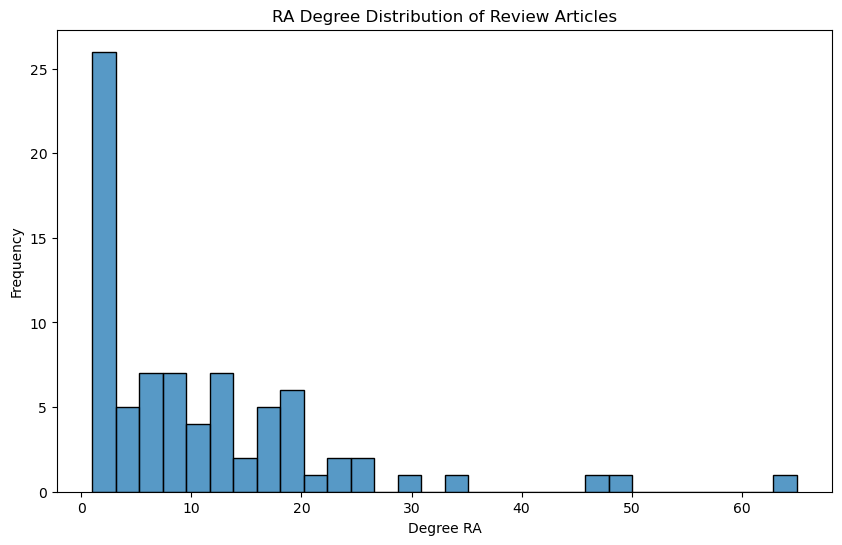

99
                                    id  \
12    https://openalex.org/W4399365390   
17    https://openalex.org/W4396575591   
26    https://openalex.org/W4400722209   
44    https://openalex.org/W4391317138   
48    https://openalex.org/W4386073876   
...                                ...   
2015  https://openalex.org/W4379382519   
2091  https://openalex.org/W4288762357   
2099  https://openalex.org/W3096574182   
2184  https://openalex.org/W3162837013   
2257  https://openalex.org/W4391129285   

                                                  title  cited_by_count  
12    Industry 4.0 supporting logistics towards smar...             2.0  
17                  Autonomous Ships: A Thematic Review             0.0  
26    Sustainable Brand Reputation: Evaluation of iP...             0.0  
44    Evaluation of Service Quality in Passenger Tra...             3.0  
48    Blockchain application in maritime supply chai...             4.0  
...                                             

In [43]:
# Let's also check if we have reviews in our list and how they perform in terms of citation cound and degree
# Substring to search for
substring = 'review'

# Get rows where 'title' contains the substring 'Python'
review_articles = lit[lit['title'].str.contains(substring, case=False, na=False)]

ra_citedby = review_articles['cited_by_count'].dropna()
print(min(ra_citedby))
print(max(ra_citedby))

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the degree distribution as a histogram
sns.histplot(ra_citedby, bins=30, kde=False, stat="count")
plt.xlabel("Cited By")
plt.ylabel("Frequency")
plt.title("Cited By Distribution of Review Articles")
plt.show()

# NOTE: the RA may not even be part of the graph in some cases
ra_ids= review_articles['id'].tolist()
# Assuming G is your graph and ra_ids is the list of node labels
filtered_ra_degrees = [G.degree[node] if node in G else None for node in ra_ids]
print(filtered_ra_degrees)

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the degree distribution as a histogram
sns.histplot(filtered_ra_degrees, bins=30, kde=False, stat="count")
plt.xlabel("Degree RA")
plt.ylabel("Frequency")
plt.title("RA Degree Distribution of Review Articles")
plt.show()

# let's check if these review articles are doing well in terms of degrees and cited count
print(len(review_articles))
print(review_articles[['id','title','cited_by_count']])

In [45]:
# Calculate node degree for each node in the network
node_degrees = dict(G.degree())

# Convert node degrees to a DataFrame for easier manipulation
degree_df = pd.DataFrame(list(node_degrees.items()), columns=['node', 'degree'])

# Set percentage of top nodes to keep (e.g., top 10%)
top_percentage = 0.20
num_nodes_to_keep = int(len(degree_df) * top_percentage)

# Sort by degree in descending order and select the top nodes
top_nodes = degree_df.sort_values(by='degree', ascending=False).head(num_nodes_to_keep)['node']

# Create a subgraph with only the top connected nodes
G_top = G.subgraph(top_nodes)

# we want toc consider only the largest connected component
connected_components = list(nx.connected_components(G_top))

# Step 2: Get the largest connected component (max by length)
largest_component = max(connected_components, key=len)

# Step 3: Create a subgraph of the largest connected component
G_lcc = G_top.subgraph(largest_component).copy()

print(G.number_of_nodes())
print(G_top.number_of_nodes())
print(G_lcc.number_of_nodes())


1298
259
257


In [46]:
# Let's create communities

# Step 1: Apply Louvain method for community detection
partition = community_louvain.best_partition(G_lcc)

# Step 2: Visualize the graph with community colors
values = [partition.get(node) for node in G_lcc.nodes()]

# Step 4: Create a force-directed layout
pos = nx.spring_layout(G_lcc, k=0.15, iterations=100)

In [47]:
# Get unique communities and map them to colors
unique_communities = set(values)
community_colors = {community: plt.cm.rainbow(i / len(unique_communities)) for i, community in enumerate(unique_communities)}

# Step 4: Create a list of handles and labels for the legend
handles = []
labels = []
for community, color in community_colors.items():
    # Create a patch for the legend with each community's color
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(f"Community {community}")

# Step 4: Display community-color mapping
print("Community to Color Mapping:")
for community, color in community_colors.items():
    print(f"Community {community}: {color}")

Community to Color Mapping:
Community 0: (np.float64(0.5), np.float64(0.0), np.float64(1.0), np.float64(1.0))
Community 1: (np.float64(0.24901960784313726), np.float64(0.38410574917192586), np.float64(0.9806347704689777), np.float64(1.0))
Community 2: (np.float64(0.0019607843137254832), np.float64(0.7092813076058535), np.float64(0.9232891061054894), np.float64(1.0))
Community 3: (np.float64(0.2529411764705882), np.float64(0.9256376597815562), np.float64(0.8301840308155507), np.float64(1.0))
Community 4: (np.float64(0.503921568627451), np.float64(0.9999810273487268), np.float64(0.7049255469061472), np.float64(1.0))
Community 5: (np.float64(0.7549019607843137), np.float64(0.9209055179449537), np.float64(0.5523649729605058), np.float64(1.0))
Community 6: (np.float64(1.0), np.float64(0.7005430375932911), np.float64(0.37841105004231035), np.float64(1.0))
Community 7: (np.float64(1.0), np.float64(0.37270199199091436), np.float64(0.18980109344182594), np.float64(1.0))


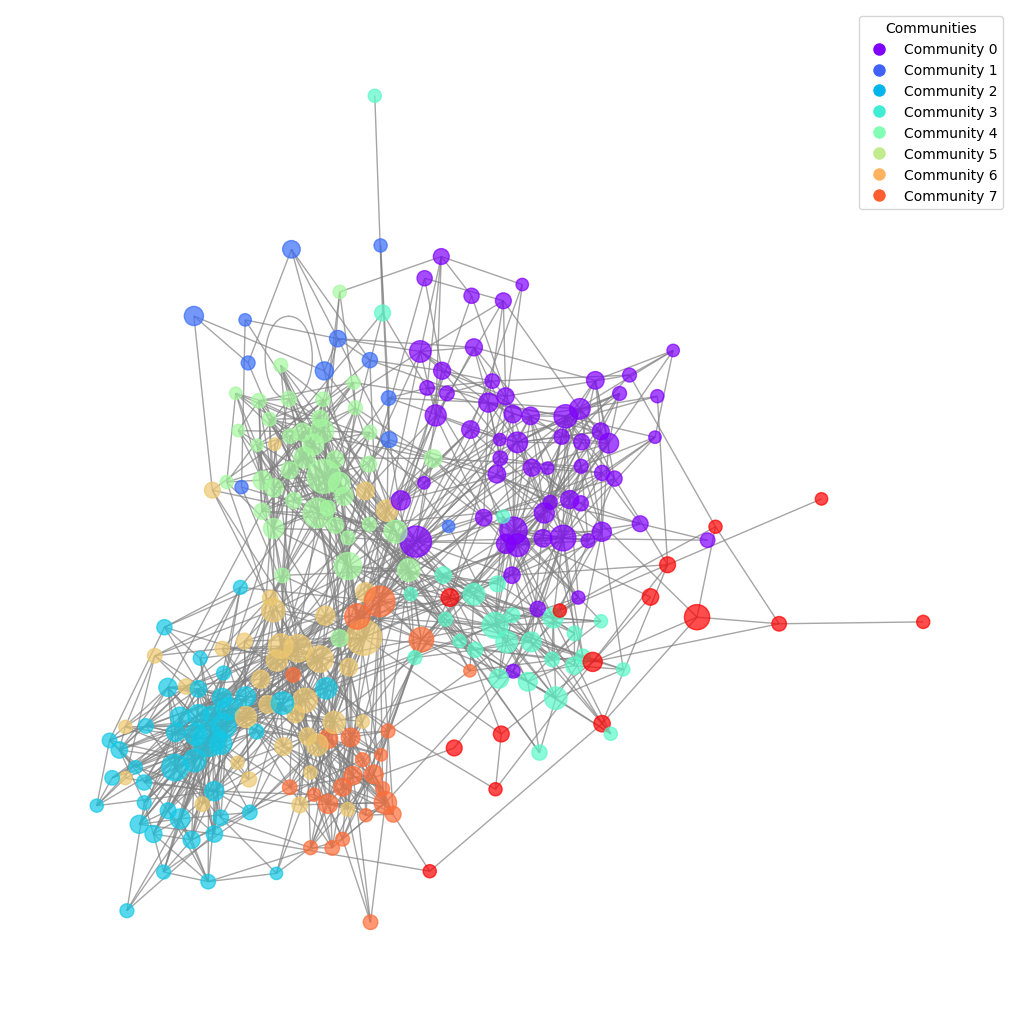

In [48]:
# Visualize the co-citation network

# Scale node sizes based on their degree in the original graph (before filtering)
node_sizes = [node_degrees[node] * 10 for node in G_lcc.nodes()]  # Multiply by 10 for visibility

plt.figure(figsize=(10, 10))  # Optional: Adjust figure size
nx.draw(G_lcc, pos, with_labels=False, node_size=node_sizes, node_color=values, cmap=plt.cm.rainbow, font_size=10, font_weight='bold', edge_color='gray', alpha=0.7)
# Add legend
plt.legend(handles=handles, labels=labels, title="Communities", loc="best", fontsize=10)
plt.show()

In [49]:
partition # this is a dictionary: the key is the article openalex id, and the value is the partition.

# we now collect the corresponding titles and link titles to partitions

partition_titles = {}
for k, v in partition.items():
    lit_f = lit[lit['id'] == k]
    if (len(lit_f)> 0):
        if v not in partition_titles:
            partition_titles[v] = [lit_f['title'].iloc[0]]
        else:
            partition_titles[v].append(lit_f['title'].iloc[0])
    else:
        print('not found')

In [50]:
# Next we use chatgpt to summarize the titles in each partition as one topic
print(partition_titles[7])

['A decision support system for vessel speed decision in maritime logistics using weather archive big data', 'Use of Convolutional Neural Networks for vessel performance optimization and safety enhancement', 'Leveraging Artificial Intelligence to Enhance Port Operation Efficiency', 'Data analysis on marine engine operating regions in relation to ship navigation', 'Ship speed prediction based on machine learning for efficient shipping operation', 'Machine learning models for predicting ship main engine Fuel Oil Consumption: A comparative study', 'An End-to-End Deep Learning Framework for Fault Detection in Marine Machinery', 'A comprehensive review on the prediction of ship energy consumption and pollution gas emissions', 'Fuel usage data analysis for efficient shipping operations', 'Prediction of Fuel Consumption for Enroute Ship Based on Machine Learning', 'A modelling system for the exhaust emissions of marine traffic and its application in the Baltic Sea area', 'Effect of ship loadi

## Next we use chatgpt to summarize the titles in each partition as one topic

### partition 0
The common theme across the research papers you provided is optimization and prediction of fuel consumption,
energy efficiency, and environmental impact in the maritime industry,
with a focus on machine learning, big data, and modeling techniques.

### partition 1
The common theme across these research papers is maritime safety, risk management, and the application of machine learning techniques to predict, analyze, and mitigate accidents and hazards in maritime operations. It also explores the intersection of autonomous ships, human factors, and intelligent systems in improving maritime safety.

### partition 2
The common theme across these research papers is machine learning, artificial intelligence, and big data applications in the maritime domain, with a focus on predictive analytics, vessel trajectory prediction, fuel consumption estimation, traffic management, cybersecurity, and autonomous ship operations.

### partition 3
The common theme across these research papers is the integration of Internet of Things (IoT), mobile edge computing, communication networks, and security within the maritime industry, with a particular focus on autonomous ships, data offloading, latency minimization, and communication technologies for maritime transportation systems.

### partition 4
The common theme across these research papers is the digital transformation and technological advancements within the maritime sector, particularly in relation to maritime logistics, container shipping, port operations, and the broader shipping supply chain. These studies explore the integration of digital twins, Industry 4.0 technologies, big data, IoT, machine learning, and artificial intelligence in improving efficiency, sustainability, and safety in maritime operations.

### partition 5
The common theme across these research papers revolves around the development and optimization of smart ports, focusing on the integration of Industry 4.0 technologies such as IoT, AI, big data, and blockchain. These studies emphasize how digitalization, automation, and energy efficiency are transforming port operations to make them more sustainable, efficient, and resilient in the face of global challenges. The research also explores the cybersecurity risks and sustainability efforts associated with green ports and smart infrastructure.

### partition 6
The common theme across these research papers is focused on maritime cybersecurity, with an emphasis on cyber risks associated with the digital transformation of the maritime industry, particularly as it pertains to the rise of autonomous vessels, smart shipping technologies, and the IoT-enabled maritime environment. These studies explore the vulnerabilities and cybersecurity challenges in both ports and ships, proposing various cyber risk assessments, threat modeling, and countermeasures to address emerging cyber threats. The papers also examine regulatory frameworks, cyber resilience training, and the impact of digitalization on ship systems, highlighting the need for proactive cybersecurity management.

### partition 7
The focus of these papers is on the adoption and application of blockchain technology in the maritime industry, specifically in areas like shipping, supply chains, and port management. The studies explore how blockchain can enhance efficiency, transparency, and sustainability within maritime logistics, including smart contracts, traceability, and decarbonization efforts. Key topics include investment strategies, barriers to adoption, collaborative platforms, and the impact of blockchain on shipping operations. These studies also examine technical sustainability, policy implications, and the business value of integrating blockchain in maritime logistics, highlighting the challenges and future potential of this transformative technology.

In [19]:
# Now we use centrality over the global graph to find the most influencial papers
# Calculate centrality
# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

# Calculate Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Calculate PageRank
pagerank = nx.pagerank(G)


# Visualize with node size based on centrality
# plt.figure(figsize=(10, 8))
# nx.draw(G, with_labels=False, node_size=[v * 1000 for v in centrality.values()])
# plt.show()

In [20]:
# Display the top 5 nodes for each centrality measure
print("Top 5 nodes by Degree Centrality:")
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 nodes by Betweenness Centrality:")
print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 nodes by Closeness Centrality:")
print(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 nodes by Eigenvector Centrality:")
print(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop 5 nodes by PageRank:")
print(sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 nodes by Degree Centrality:
[('https://openalex.org/W3041382323', 0.05011565150346954), ('https://openalex.org/W4399283331', 0.044718581341557435), ('https://openalex.org/W2978644098', 0.04240555127216654), ('https://openalex.org/W2964482263', 0.03855050115651503), ('https://openalex.org/W4400493457', 0.03700848111025443)]

Top 5 nodes by Betweenness Centrality:
[('https://openalex.org/W3041382323', 0.11878184093636855), ('https://openalex.org/W4400493457', 0.0862369578746974), ('https://openalex.org/W2964482263', 0.07669997543402837), ('https://openalex.org/W4386245296', 0.050334142047570585), ('https://openalex.org/W4205557186', 0.0418721600603818)]

Top 5 nodes by Closeness Centrality:
[('https://openalex.org/W3041382323', 0.3261451499654046), ('https://openalex.org/W4400493457', 0.31977663520276656), ('https://openalex.org/W4386245296', 0.3132884136189423), ('https://openalex.org/W2964482263', 0.31049842774643804), ('https://openalex.org/W4225993858', 0.3027577106401543)]

To

In [76]:
display(lit[lit['id'] == 'https://openalex.org/W3213918042' ]['title'])
display(lit[lit['id'] == 'https://openalex.org/W3213918042' ]['publication_date'])

1154    Blockchain adoption in the maritime supply cha...
Name: title, dtype: object

1154    2021-11-08
Name: publication_date, dtype: object